# Validating simulated discharge

One typical use case is to validate simulated discharge with observations. In this example, observations from GRDC are used. *pcrglobwb_utils* facilitates reading time series from netCDF-output at either user-specified or GRDC-specified coordinates, plotting time series of simulation and observation, and computing evaluation metrics.

## Preambule

Loading required packages and showing package versions used.

In [1]:
%matplotlib inline
import pcrglobwb_utils
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import spotpy as sp
import os, sys
import datetime

In [2]:
print('this notebook was created using Python', str((sys.version)), 'on a', str(sys.platform),'on', datetime.datetime.now())

this notebook was created using Python 3.8.5 | packaged by conda-forge | (default, Jul 31 2020, 01:53:45) [MSC v.1916 64 bit (AMD64)] on a win32 on 2021-07-15 10:44:11.157586


In [3]:
pcrglobwb_utils.utils.print_versions()

pcrglobwb_utils version 0.2.4b
pandas version 1.2.4
xarray version 0.18.2
numpy version 1.20.3
geopandas version 0.9.0
rasterio version 1.1.5
rioxarray version 0.4.2


## Loading GRDC data

For this showcase, we use daily observations at a station in the Amazon River basin. With *pcrglobwb_utils*, it is possible to automatically retrieve the name of the station from file as well as the coordinates associated with this station. Note that the coordinates provided by GRDC do not always coincide with the PCR-GLOBWB river network and thus the location should be double-checked - good that *pcrglobwb_utils* got you covered!

In [4]:
grdc_data = pcrglobwb_utils.obs_data.grdc_data('example_data/GRDC/files/3629000_Obidos.day')

In [5]:
plot_title, props = grdc_data.get_grdc_station_properties()
print(plot_title)
print(props)

station OBIDOS - PORTO at latitude/longitude -1.947200/-55.511100
{'station': 'OBIDOS - PORTO', 'latitude': -1.9472, 'longitude': -55.5111}


With all this information, let's plot the values of the 'discharge' variable from the netCDF-output together with the location of the GRDC-file.

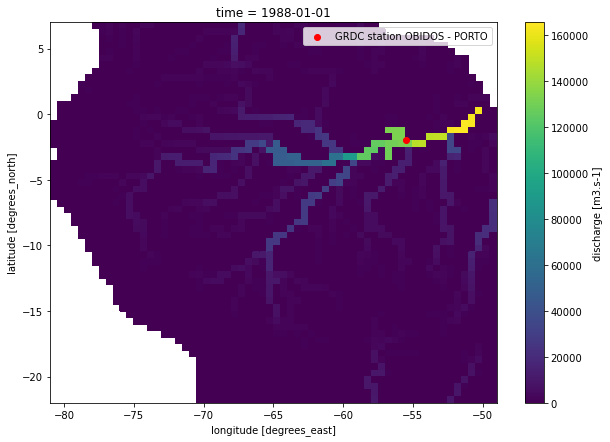

In [6]:
plt.figure(figsize=(10,7))
pcrglobwb_utils.plotting.plot_var_at_timestep('example_data/GRDC/DUMMY_discharge_dailyTot_output.nc', 
                                              var_name='discharge', 
                                              time='1988-01-01')
plt.scatter(props['longitude'], props['latitude'], c='r', label='GRDC station {}'.format(props['station']))
plt.legend();

We have now a lot of meta-data, let's read the actual observed discharge from the file and plot the time series.

In [7]:
df_GRDC, props = grdc_data.get_grdc_station_values(var_name='Q$obs$ GRDC [m3/s]', col_name=' Original')

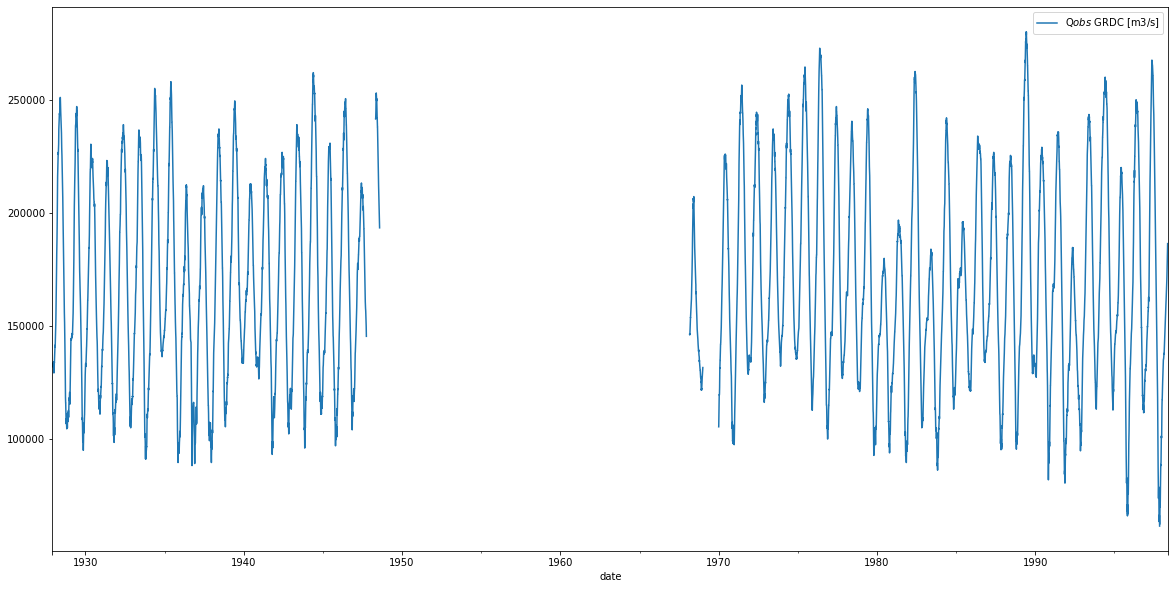

In [8]:
df_GRDC.plot(figsize=(20,10));

## Loading PCR-GLOBWB data

We now know where the GRDC-station is located, but not to which cell (expressed as row/column combination) this location corresponds. Let's derive this information!

By means of the row/column combination, we can extract the simulated discharge values from the netCDF-file from this cell.

In [12]:
pcr_data = pcrglobwb_utils.sim_data.from_nc('example_data/GRDC/DUMMY_discharge_dailyTot_output.nc')

In [13]:
row, col = pcr_data.find_indices_from_coords(props['longitude'], props['latitude'])

In [16]:
print('The location {} with its latitude {} and longitude {} corresponds to the cell with row and cell indeces {}'.format(props['station'], 
                                                                                                                         props['latitude'], 
                                                                                                                         props['longitude'],
                                                                                                                         (row, col)))

The location OBIDOS - PORTO with its latitude -1.9472 and longitude -55.5111 corresponds to the cell with row and cell indeces (17, 50)


In [14]:
q_sim_obidos = pcr_data.read_values_at_indices(row, col, plot_var_name='Q$sim$ PCR-GLOBWB [m3/s]', plot=False)

## Validating simulated discharge with observations

Visualizing time series of simulation and observation shows a) that our example simulation data covers only a small part of the available observations, and b) that simulated discharge agrees quite good with GRDC data.

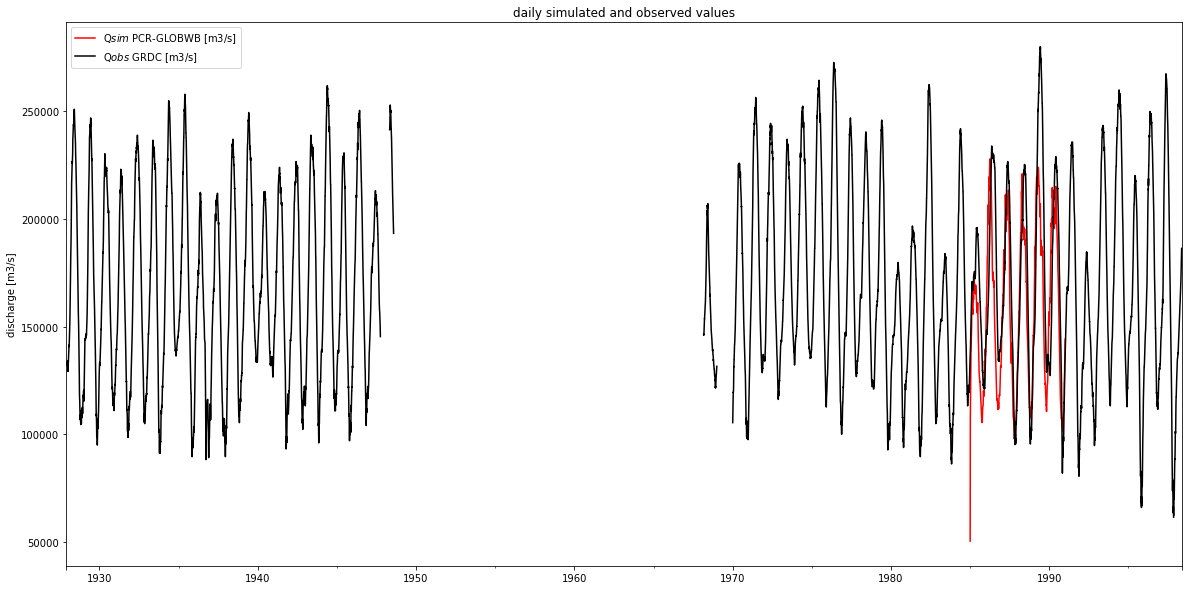

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
q_sim_obidos.plot(ax=ax, c='r')
df_GRDC.plot(ax=ax, c='k')
ax.set_ylabel('discharge [m3/s]')
ax.set_xlabel(None)
plt.legend()
plt.title('daily simulated and observed values');

*pcrglobwb_utils* allows for validating simulations with observations and returns the KGE (optionally with all components), NSE, RMSE and coefficient of determination r2.

In [19]:
scores = pcr_data.validate_results(df_GRDC, out_dir='./_OUT', return_all_KGE=False)

In [20]:
scores

,KGE,NSE,MSE,RMSE,R2
0,0.712195,0.496277,9.555419e+08,30911.840814,0.599577
